<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# GA Capstone: Fake News Classifier

Author: Tan Kai Yong Alvin

# Notebook 2-1: Modeling
In this section, we will apply machine learning models which uses the n-gram approach, whereby frequency of occurrence of each word is used as a feature to train the mode for fake news classification.

## Libraries

In [1]:
import pandas as pd
import numpy as np
import requests
import matplotlib.pyplot as plt
import seaborn as sns
import time
import re

# preprocessing of data
from nltk.tokenize import word_tokenize, RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer

# modelling
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV # split our data and run hyperparameter search
from sklearn.pipeline import Pipeline # to compactly pack multiple modeling operations
from sklearn.naive_bayes import MultinomialNB # to build our classification model
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, plot_roc_curve, roc_auc_score # to access results from binary classification task (you may also import other specific classification metrics)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# this setting widens how many characters pandas will display in a column:
pd.options.display.max_colwidth = 400

## Import

In [2]:
classification_df = pd.read_csv('./datasets/classification_df.csv')

In [3]:
classification_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44689 entries, 0 to 44688
Data columns (total 4 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   date                 44679 non-null  object
 1   original_title_text  44689 non-null  object
 2   classification_text  44680 non-null  object
 3   label                44689 non-null  int64 
dtypes: int64(1), object(3)
memory usage: 1.4+ MB


In [4]:
classification_df.head()

,date,original_title_text,classification_text,label
0,2017-12-31,"As U.S. budget fight looms, Republicans flip their fiscal script WASHINGTON (Reuters) - The head of a conservative Republican faction in the U.S. Congress, who voted this month for a huge expansion of the national debt to pay for tax cuts, called himself a “fiscal conservative” on Sunday and urged budget restraint in 2018. In keeping with a sharp pivot under way among Republicans, U.S. Represe...",u budget fight loom republican flip fiscal script washington head conservative republican faction u congress voted month huge expansion national debt pay tax cut called fiscal conservative sunday urged budget restraint 2018 keeping sharp pivot way among republican u representative mark meadow speaking cbs face nation drew hard line federal spending lawmaker bracing battle january return holida...,0
1,2017-12-29,"U.S. military to accept transgender recruits on Monday: Pentagon WASHINGTON (Reuters) - Transgender people will be allowed for the first time to enlist in the U.S. military starting on Monday as ordered by federal courts, the Pentagon said on Friday, after President Donald Trump’s administration decided not to appeal rulings that blocked his transgender ban. Two federal appeals courts, one in ...",u military accept transgender recruit monday pentagon washington transgender people allowed first time enlist u military starting monday ordered federal court pentagon said friday president donald trump administration decided appeal ruling blocked transgender ban two federal appeal court one washington one virginia last week rejected administration request put hold order lower court judge requ...,0
2,2017-12-31,"Senior U.S. Republican senator: 'Let Mr. Mueller do his job' WASHINGTON (Reuters) - The special counsel investigation of links between Russia and President Trump’s 2016 election campaign should continue without interference in 2018, despite calls from some Trump administration allies and Republican lawmakers to shut it down, a prominent Republican senator said on Sunday. Lindsey Graham, who se...",senior u republican senator let mr mueller job washington special counsel investigation link russia president trump 2016 election campaign continue without interference 2018 despite call trump administration ally republican lawmaker shut prominent republican senator said sunday lindsey graham serf senate armed force judiciary committee said department justice special counsel robert mueller nee...,0
3,2017-12-30,"FBI Russia probe helped by Australian diplomat tip-off: NYT WASHINGTON (Reuters) - Trump campaign adviser George Papadopoulos told an Australian diplomat in May 2016 that Russia had political dirt on Democratic presidential candidate Hillary Clinton, the New York Times reported on Saturday. The conversation between Papadopoulos and the diplomat, Alexander Downer, in London was a driving factor...",fbi russia probe helped australian diplomat tipoff nyt washington trump campaign adviser george papadopoulos told australian diplomat may 2016 russia political dirt democratic presidential candidate hillary clinton new york time reported saturday conversation papadopoulos diplomat alexander downer london driving factor behind fbi decision open counterintelligence investigation moscow contact t...,0
4,2017-12-29,"Trump wants Postal Service to charge 'much more' for Amazon shipments SEATTLE/WASHINGTON (Reuters) - President Donald Trump called on the U.S. Postal Service on Friday to charge “much more” to ship packages for Amazon (AMZN.O), picking another fight with an online retail giant he has criticized in the past. “Why is the United States Post Office, which is losing many billions of dollars a y...",trump want postal service charge much amazon shipment seattlewashington president donald trump called u postal service friday charge much ship package amazon amzno picking another fight online retail giant criticized past united state post office losing many billion do

In [5]:
# check for nulls
# the nulls in the dates column will not be processed for now as it will not be used for the assessment
classification_df[classification_df['classification_text'].isnull()]

,date,original_title_text,classification_text,label
30569,NaN,https://100percentfedup.com/served-roy-moore-vietnamletter-veteran-sets-record-straight-honorable-decent-respectable-patriotic-commander-soldier/ https://100percentfedup.com/served-roy-moore-vietnamletter-veteran-sets-record-straight-honorable-decent-respectable-patriotic-commander-soldier/,NaN,1
36715,NaN,https://100percentfedup.com/video-hillary-asked-about-trump-i-just-want-to-eat-some-pie/ https://100percentfedup.com/video-hillary-asked-about-trump-i-just-want-to-eat-some-pie/,NaN,1
36716,NaN,https://100percentfedup.com/12-yr-old-black-conservative-whose-video-to-obama-went-viral-do-you-really-love-america-receives-death-threats-from-left/ https://100percentfedup.com/12-yr-old-black-conservative-whose-video-to-obama-went-viral-do-you-really-love-america-receives-death-threats-from-left/,NaN,1
37047,NaN,https://fedup.wpengine.com/wp-content/uploads/2015/04/hillarystreetart.jpg https://fedup.wpengine.com/wp-content/uploads/2015/04/hillarystreetart.jpg,NaN,1
37048,NaN,https://fedup.wpengine.com/wp-content/uploads/2015/04/entitled.jpg https://fedup.wpengine.com/wp-content/uploads/2015/04/entitled.jpg,NaN,1
38640,NaN,https://fedup.wpengine.com/wp-content/uploads/2015/04/hillarystreetart.jpg https://fedup.wpengine.com/wp-content/uploads/2015/04/hillarystreetart.jpg,NaN,1
38641,NaN,https://fedup.wpengine.com/wp-content/uploads/2015/04/entitled.jpg https://fedup.wpengine.com/wp-content/uploads/2015/04/entitled.jpg,NaN,1
43077,NaN,https://fedup.wpengine.com/wp-content/uploads/2015/04/hillarystreetart.jpg https://fedup.wpengine.com/wp-content/uploads/2015/04/hillarystreetart.jpg,NaN,1
43078,NaN,https://fedup.wpengine.com/wp-content/uploads/2015/04/entitled.jpg https://fedup.wpengine.com/wp-content/uploads/2015/04/entitled.jpg,NaN,1


In [6]:
# these nulls are made up of white spaces with title comprising of URLs, since they are not useful for prediction, the rows will be dropped.
classification_df.dropna(subset=['classification_text'], inplace = True)
classification_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 44680 entries, 0 to 44688
Data columns (total 4 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   date                 44679 non-null  object
 1   original_title_text  44680 non-null  object
 2   classification_text  44680 non-null  object
 3   label                44680 non-null  int64 
dtypes: int64(1), object(3)
memory usage: 1.7+ MB


In [7]:
# classification_df['date'] = pd.to_datetime(classification_df['date'])

In [8]:
# define X and y
X = classification_df['classification_text']
y = classification_df['label']

## Train/ Test Split

In [9]:
# Define training and testing sets. Train/test split.
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.25,
                                                    stratify=y,
                                                    random_state=42)

## Null Model

In [10]:
y_test.value_counts(normalize = True)

1    0.525246
0    0.474754
Name: label, dtype: float64

The data set is balanced. In this case, predicting everything as the majority class will give us 52.3 % accuracy.

Since the aim of the project is a binary classification problem with a balanced data set, the metric 'Accuracy' will be used to score and evaluate the model. 

In addition, I will also be prioritising minimising of fake news being classified as real news (false negative rate). In this context, it is more detrimental when a fake news is being classified as real news as fake news may be misleading and cause unnecessary destress or societal unrest. As such, we will also evaulate base on the 'Recall' metric.

## Baseline Model: Naive Bayes with Count Vectorizer

First, I will apply the Multinomial Naive Bayes with count vectorizer as our baseline model.

In [11]:
cvec = CountVectorizer()

In [12]:
X_train_data_features_cvec = cvec.fit_transform(X_train)
X_test_data_features_cvec = cvec.transform(X_test)

In [13]:
nb = MultinomialNB()

In [14]:
nb.fit(X_train_data_features_cvec, y_train)

MultinomialNB()

In [15]:
nb.score(X_train_data_features_cvec, y_train)

0.9618024470307371

In [16]:
cross_val_score(nb, X_train_data_features_cvec, y_train, cv=5).mean()

0.9504923903312443

In [17]:
nb.score(X_test_data_features_cvec, y_test)

0.9542524619516563

In [18]:
# Get predictions
preds = nb.predict(X_test_data_features_cvec)
print(preds)

[0 1 1 ... 1 1 0]


In [19]:
# confusion matrix yields a 2-D array
confusion_matrix(y_test, preds) 

array([[5054,  249],
       [ 262, 5605]], dtype=int64)

In [20]:
# ravel() to convert to 1-D and Save confusion matrix values
tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()
print(tn, fp, fn, tp)

5054 249 262 5605


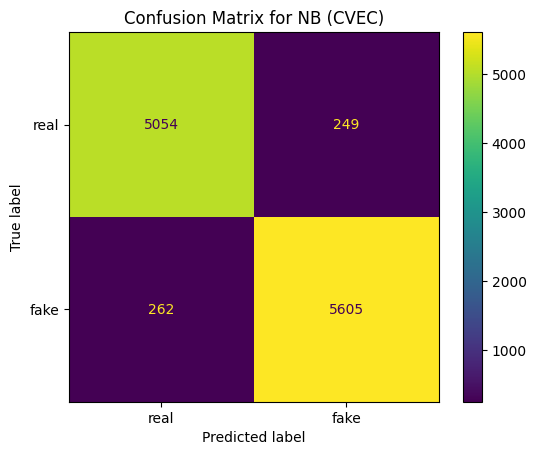

In [21]:
# plot confusion matrix
cm = confusion_matrix(y_test, preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['real', 'fake'])
disp.plot()
plt.title('Confusion Matrix for NB (CVEC)', fontsize =12);

## Model 2: Naive Bayes with TF-IDF Vectorizer

In [22]:
# Using pipeline, we will 
# instantiate a pipeline class with the following 2 as its list items:
# 1. TfidfVectorizer (transformer)
# 2. Multinomial Naive Bayes (estimator)

pipe_tvec_nb = Pipeline([
    ('tvec', TfidfVectorizer()), # tuple for transformer object, class
    ('nb', MultinomialNB()) # tuple for estimator object, class
])

In [23]:
pipe_tvec_nb_params = {
    'tvec__max_features': [1000, 2000, 3000], 
    'tvec__min_df': [1, 2],
    'tvec__max_df': [0.95, .9],
    'tvec__ngram_range': [(1,1), (1,2), (1,3)] 
} 

In [24]:
# Instantiate GridSearchCV.
gs_tvec_nb = GridSearchCV(pipe_tvec_nb, # the object that we are optimizing
                  param_grid=pipe_tvec_nb_params, 
                  cv=5) # 5-fold cross-validation.

In [25]:
# Fit GridSearch to training data.

In [26]:
%%time
gs_tvec_nb.fit(X_train, y_train)

CPU times: total: 1h 13min 39s
Wall time: 1h 14min 10s


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tvec', TfidfVectorizer()),
                                       ('nb', MultinomialNB())]),
             param_grid={'tvec__max_df': [0.95, 0.9],
                         'tvec__max_features': [1000, 2000, 3000],
                         'tvec__min_df': [1, 2],
                         'tvec__ngram_range': [(1, 1), (1, 2), (1, 3)]})

In [27]:
print(gs_tvec_nb.best_score_) # best score

0.9314831393613847


In [28]:
# Score model on training set.
gs_tvec_nb.score(X_train, y_train)

0.9328857057594748

In [29]:
# Score model on testing set.
gs_tvec_nb.score(X_test, y_test)

0.9331244404655327

In [30]:
gs_tvec_nb.best_params_

{'tvec__max_df': 0.95,
 'tvec__max_features': 3000,
 'tvec__min_df': 2,
 'tvec__ngram_range': (1, 3)}

In [31]:
# Get predictions
preds = gs_tvec_nb.predict(X_test)
print(preds)

[0 1 1 ... 1 1 0]


In [32]:
# confusion matrix yields a 2-D array
confusion_matrix(y_test, preds) 

array([[4882,  421],
       [ 326, 5541]], dtype=int64)

In [33]:
# ravel() to convert to 1-D and Save confusion matrix values
tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()
print(tn, fp, fn, tp)

4882 421 326 5541


## Model 3 Naive Bayes with TF-IDF Vectorizer (Further Tuning)

In [34]:
# Using pipeline, we will 
# instantiate a pipeline class with the following 2 as its list items:
# 1. TfidfVectorizer (transformer)
# 2. Multinomial Naive Bayes (estimator)

pipe_tvec_nb = Pipeline([
    ('tvec', TfidfVectorizer(max_df = 0.95)), # tuple for transformer object, class
    ('nb', MultinomialNB()) # tuple for estimator object, class
])

In [35]:
pipe_tvec_nb_params = {
    'tvec__max_features': [2500, 3000, 3500], 
    'tvec__min_df': [2, 3, 4],
    'tvec__ngram_range': [(1,2), (1,3)] 
} 

In [36]:
# Instantiate GridSearchCV.
gs_tvec_nb = GridSearchCV(pipe_tvec_nb, # the object that we are optimizing
                  param_grid=pipe_tvec_nb_params, 
                  cv=5) # 5-fold cross-validation.

In [37]:
# Fit GridSearch to training data.

In [38]:
%%time
gs_tvec_nb.fit(X_train, y_train)

CPU times: total: 49min 43s
Wall time: 49min 50s


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tvec', TfidfVectorizer(max_df=0.95)),
                                       ('nb', MultinomialNB())]),
             param_grid={'tvec__max_features': [2500, 3000, 3500],
                         'tvec__min_df': [2, 3, 4],
                         'tvec__ngram_range': [(1, 2), (1, 3)]})

In [39]:
print(gs_tvec_nb.best_score_) # best score

0.932915547597732


In [40]:
# Score model on training set.
gs_tvec_nb.score(X_train, y_train)

0.9344971650253656

In [41]:
# Score model on testing set.
gs_tvec_nb.score(X_test, y_test)

0.9358997314234557

In [42]:
gs_tvec_nb.best_params_

{'tvec__max_features': 3500, 'tvec__min_df': 2, 'tvec__ngram_range': (1, 3)}

In [43]:
# Get predictions
preds = gs_tvec_nb.predict(X_test)
print(preds)

[0 1 1 ... 1 1 0]


In [44]:
# confusion matrix yields a 2-D array
confusion_matrix(y_test, preds) 

array([[4887,  416],
       [ 300, 5567]], dtype=int64)

In [45]:
# ravel() to convert to 1-D and Save confusion matrix values
tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()
print(tn, fp, fn, tp)

4887 416 300 5567


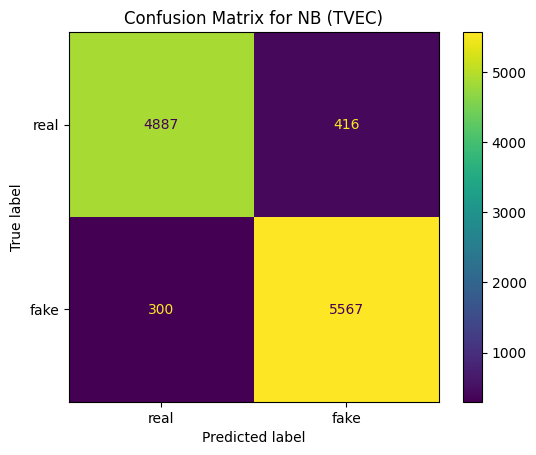

In [46]:
# plot confusion matrix
cm = confusion_matrix(y_test, preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['real', 'fake'])
disp.plot()
plt.title('Confusion Matrix for NB (TVEC)', fontsize =12);

## Summary of Preliminary Observations from Model

* The baseline model using Naive Bayes with Count Vectorizer is able to outperform the TD-IDF vectorizer. Hence, we will optimise the model while using Count vectorizer for vectorization.
* max_df of the count vectorizer to be fixed at 0.95 as this gives the optimal performance.
* Hyperparameter tuning of the max features have minimal impact on the metric performance but will have significant impact on the computational effort and time. Increasing the max_features to 3500 only showed marginal improvement in the accuracy scores. Hence, the max_feature will be set as 3000. 
* Model is able to perform best with n_gram range set at (1,3).While the higher value of n (4-grams, 5-grams, etc.) may improve the accuracy of the model, it will  have significant demands on hardware and software, calculation time. Hence, we will only be considering up to trigram.